In [4]:
#importing libraries and packages
import sys,os,time
print(sys.executable)
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.markers
from pandas.tseries.frequencies import to_offset# needed to set the time offset to match to the muons DF
import seaborn as sns
from numpy import argmax
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.datasets import make_regression
from sklearn.preprocessing import LabelEncoder

from datetime import datetime, timedelta

from __future__ import print_function
import json




/usr/bin/python3


/tmp/ipykernel_2209886/2445403248.py:11: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  dfpt1 = dfpt.loc[t1start:t1end].copy()
/tmp/ipykernel_2209886/2445403248.py:141: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  merged_df_1day = merged_df1.loc[yesterday:now].copy()
/tmp/ipykernel_2209886/2445403248.py:142: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  merged_df_31days = merged_df1.loc[lastmonth:now].copy()


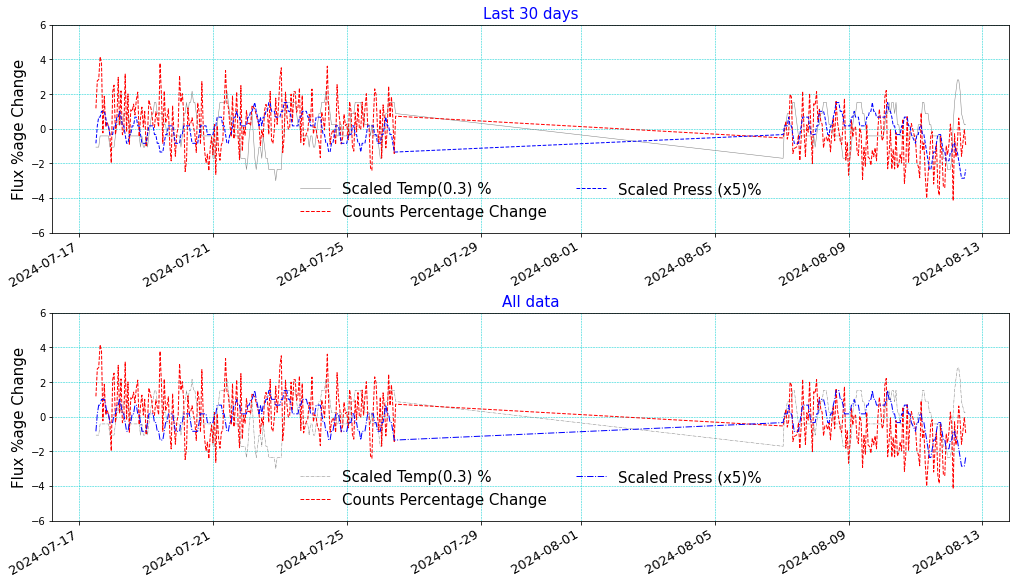

In [35]:
import sys, os, time
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.frequencies import to_offset

def merge_tables(df1, dfpt):
    t1start = pd.Timestamp(df1.index[0]).tz_localize(None)
    t1end = pd.Timestamp(df1.index[-1]).tz_localize(None)
    dfpt1 = dfpt.loc[t1start:t1end].copy()
    merged_tab = pd.merge(df1, dfpt1, how='inner', left_index=True, right_index=True)
    return merged_tab

def calc_percent_change(merged_df):
    merged_df["counts_pct"] = ((merged_df['counts12'] - merged_df['counts12'].mean()) / merged_df['counts12'].mean() * 100)
    merged_df["counts_m_avg"] = merged_df["counts_pct"].rolling('6H').mean()
    merged_df["press_pct"] = 5 * ((merged_df['alti'] - merged_df['alti'].mean()) / merged_df['alti'].mean() * 100)
    merged_df["temp_pct"] = ((merged_df['tmpf'] - merged_df['tmpf'].mean()) / merged_df['tmpf'].mean() * 100)
    merged_df['temp_scaled'] = 0.3 * merged_df['temp_pct']
    merged_df["delta_cts"] = np.log((merged_df["counts12"]) / merged_df["counts12"].mean())
    merged_df["delta_pres"] = (merged_df["alti"] - merged_df["alti"].mean())
    return merged_df

# Specify the directory where your log files are stored
log_directory = '/home/cosmic/Colombo/newCmbDetector/ColomboPi4/muonData'

# Get a list of all files in the directory
all_files = os.listdir(log_directory)

# Filter only files with a specific extension (e.g., '.log')
log_files = [file for file in all_files if file.endswith('.log')]

# Initialize an empty DataFrame
merged_df1 = pd.DataFrame()

# Iterate through each log file
for log_file in log_files:
    # Create the full path for the log file
    log_file_path = os.path.join(log_directory, log_file)
  
    # Read the log file into a DataFrame
    df = pd.read_csv(log_file_path, sep=',', names=["rawCounts", "dark_counts", "counts12", "counts13", "counts23", "datetime"])
    
    # Ensure the datetime column is in the correct format, localize to Asia/Colombo, then convert to UTC
    df["datetime"] = pd.to_datetime(df["datetime"], errors='coerce').dt.floor('min')
    df["datetime"] = df["datetime"].dt.tz_localize('Asia/Colombo', ambiguous='infer')  # Localize to Asia/Colombo
    df["datetime"] = df["datetime"].dt.tz_convert('UTC')  # Convert to UTC
    
    # Append the DataFrame to the merged_df1 DataFrame
    merged_df1 = pd.concat([merged_df1, df], axis=0, ignore_index=True)

# Drop non-numeric columns and unnecessary columns
merged_df1 = merged_df1.drop(columns=["rawCounts", "dark_counts"])

# Ensure the counts columns are numeric
merged_df1["counts12"] = pd.to_numeric(merged_df1["counts12"], errors='coerce')
merged_df1["counts13"] = pd.to_numeric(merged_df1["counts13"], errors='coerce')
merged_df1["counts23"] = pd.to_numeric(merged_df1["counts23"], errors='coerce')

# Create a continuous date-time range
date_range = pd.date_range(start=merged_df1["datetime"].min(), end=merged_df1["datetime"].max(), freq='1T')

complete_df = pd.DataFrame(date_range, columns=['datetime'])

# Merge the complete range with the original dataframe
merged_df1 = pd.merge(complete_df, merged_df1, on="datetime", how='left')

# Identify hours with any missing data and set the entire hour's data to NaN
merged_df1['hour'] = merged_df1['datetime'].dt.floor('H')
missing_hours = merged_df1[merged_df1['counts12'].isna()]['datetime'].dt.floor('H').unique()

# Create a boolean mask to identify rows where 'hour' is in missing_hours
mask = merged_df1['hour'].isin(missing_hours)

# Set all columns except the datetime column to NaN where the mask is True
merged_df1.loc[mask, merged_df1.columns != 'datetime'] = np.nan

# Drop the 'hour' column as it was only needed for processing
merged_df1 = merged_df1.drop(columns=['hour'])

# Set the datetime column as the index
merged_df1 = merged_df1.set_index('datetime')

# Function to replace consecutive zeros with the average of nearest non-zero values
def replace_zeros_with_avg(df, col_name):
    zero_mask = (df[col_name] == 0)
    zero_groups = zero_mask.ne(zero_mask.shift()).cumsum()  # Create groups of consecutive zeros
    for group, values in df.loc[zero_mask, col_name].groupby(zero_groups):
        if len(values) > 0:
            before = df.loc[values.index.min() - pd.Timedelta(hours=1), col_name] if values.index.min() > df.index.min() else np.nan
            after = df.loc[values.index.max() + pd.Timedelta(hours=1), col_name] if values.index.max() < df.index.max() else np.nan
            avg = np.nanmean([before, after])
            df.loc[values.index, col_name] = avg

# Apply the function to 'counts12', 'counts13', and 'counts23' columns
replace_zeros_with_avg(merged_df1, 'counts12')
replace_zeros_with_avg(merged_df1, 'counts13')
replace_zeros_with_avg(merged_df1, 'counts23')

# Resample to hourly data
df_hourly = merged_df1[['counts12', 'counts13', 'counts23']].resample('H').sum()

df_hourly.drop(df_hourly.head(1).index, inplace=True)
df_hourly.drop(df_hourly.tail(1).index, inplace=True)

# Filter out data based on a range for hourly counts (e.g., counts12 between 7000 and 8000)
min_count = 6000
max_count = 9000
df_hourly = df_hourly[(df_hourly['counts12'] >= min_count) & (df_hourly['counts12'] <= max_count)]

# Process the weather data
fPT1 = 'colombo_alti_temp.csv'
df1_PT = pd.read_csv(fPT1)
df1_PT.drop(df1_PT[df1_PT['alti'] == 'M'].index, inplace=True)
df1_PT.drop(df1_PT[df1_PT['tmpf'] == 'M'].index, inplace=True)
df1_PT.dropna(inplace=True)

# Ensure the datetime column is in UTC
df1_PT['valid'] = pd.to_datetime(df1_PT['valid'], utc=True)
df1_PT = df1_PT.set_index('valid')

# Offset adjustment (if needed)
loffset = '-10min'
df1_PT.index = df1_PT.index + to_offset(loffset)

df1_PT["alti"] = df1_PT["alti"].astype(str).astype(float)
df1_PT["tmpf"] = df1_PT["tmpf"].astype(str).astype(float)

# Merge datasets
merged_df1 = merge_tables(df1_PT, df_hourly)
merged_df1 = merged_df1.rename_axis('date')
merged_df1.to_csv('/home/cosmic/Colombo/newCmbDetector/ColomboPi4/muonData/newColombo_merged.csv')

# Define time ranges
now = datetime.utcnow().date()
yesterday = datetime.utcnow().date() - timedelta(days=1)
lastmonth = datetime.utcnow().date() - timedelta(days=31)

# Create datasets for specific periods
merged_df_1day = merged_df1.loc[yesterday:now].copy()
merged_df_31days = merged_df1.loc[lastmonth:now].copy()

# Calculate percentage changes
merged_df = calc_percent_change(merged_df1)
calc_percent_change(merged_df_1day)
calc_percent_change(merged_df_31days)

# Plotting
fig = plt.figure(figsize=(14, 8), constrained_layout=True)
gs = fig.add_gridspec(2)
axs = gs.subplots(sharex=False, sharey=False)

axs[0].set_title("Last 30 days", fontsize=15, color='blue')
axs[0].plot(merged_df_31days['temp_scaled'],
            linestyle='-', linewidth=0.5, color='gray', label='Scaled Temp(0.3) %')
axs[0].plot(merged_df_31days['counts_pct'],
            linestyle='--', linewidth=1, color='red', label='Counts Percentage Change')
axs[0].plot(merged_df_31days['press_pct'],
            linestyle='--', linewidth=1, color='blue', label='Scaled Press (x5)%')

axs[1].set_title("All data", fontsize=15, color='blue')
axs[1].plot(merged_df['temp_scaled'],
            linestyle='-.', linewidth=0.5, color='gray', label='Scaled Temp(0.3) %')
axs[1].plot(merged_df["counts_pct"],
            linestyle='--', linewidth=1, color='red', label='Counts Percentage Change')
axs[1].plot(merged_df["press_pct"],
            linestyle='-.', linewidth=1, color='blue', label='Scaled Press (x5)%')

axs[0].set_ylabel('Flux %age Change', fontsize=15)
axs[0].set_ylim(-6, 6)
axs[0].legend(ncol=2, frameon=False, fontsize=15)
axs[0].tick_params(axis='x', labelsize=13)
axs[0].grid(True, color='DarkTurquoise', alpha=1, linestyle='--', linewidth=0.5)

axs[1].set_ylabel('Flux %age Change', fontsize=15)
axs[1].set_ylim(-6, 6)
axs[1].legend(ncol=2, frameon=False, fontsize=15)
axs[1].tick_params(axis='x', labelsize=13)
axs[1].grid(True, color='DarkTurquoise', alpha=1, linestyle='--', linewidth=0.5)

plt.setp(axs[1].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(axs[0].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.savefig('/home/cosmic/onlineMon/images/newColombo_pct_Ch_mostrecent.png')
plt.show()
